## KNN

result:  [[0.]] 
 neighbours:  [[1. 0. 0.]] 
 distance:  [[101. 104. 337.]]


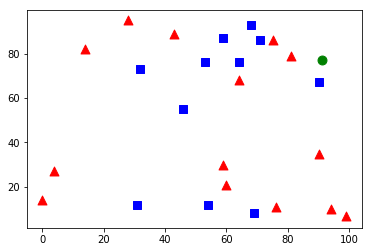

In [5]:
import numpy as np
from  matplotlib import pyplot as plt 
import cv2
# Feature set containing (x,y) values of 25 known/training data
trainData = np.random.randint(0,100,(25,2)).astype(np.float32)
# Labels each one either Red or Blue with numbers 0 and 1
responses = np.random.randint(0,2,(25,1)).astype(np.float32)
# Take Red families and plot them
red = trainData[responses.ravel()==0]
plt.scatter(red[:,0],red[:,1],80,'r','^')
# Take Blue families and plot them
blue = trainData[responses.ravel()==1]
plt.scatter(blue[:,0],blue[:,1],80,'b','s')

newcomer = np.random.randint(0,100,(1,2)).astype(np.float32)
plt.scatter(newcomer[:,0],newcomer[:,1],80,'g','o')
knn = cv2.ml.KNearest_create()

knn.train(trainData, cv2.ml.ROW_SAMPLE,responses)
ret, results, neighbours ,dist = knn.findNearest(newcomer, 3)
print("result: ", results,"\n","neighbours: ", neighbours,"\n","distance: ", dist) 
plt.show()

In [13]:
# prdict many dots
newcomers = np.random.randint(0,100,(10,2)).astype(np.float32)
ret, results, neighbours ,dist = knn.findNearest(newcomer, 3)

### kNN 手写数字 OCR

In [73]:
img = cv2.imread('../samples/data/digits.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Now we split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)] # 横切50份，纵切100份
# Make it into a Numpy array. It size will be (50,100,20,20)
x = np.array(cells)
# Now we prepare train_data and test_data.
train = x[:,:50].reshape(-1,400).astype(np.float32) # Size = (2500,400) # 前50份训练集
test = x[:,50:100].reshape(-1,400).astype(np.float32) # Size = (2500,400)# 后50份测试集

# Create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k,250)[:,np.newaxis]
test_labels = train_labels.copy()

# Initiate kNN, train the data, then test it with test data for k=1
knn = cv2.ml.KNearest_create()

knn.train(train, cv2.ml.ROW_SAMPLE,train_labels)
ret, results, neighbours ,dist = knn.findNearest(test, 3)

matches = results==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/results.size
print ('Accuracy is {} %'.format(accuracy))

Accuracy is 91.64 %


In [77]:
train_labels.shape

(2500, 1)

In [38]:
np.savez('../model_data/knn_data.npz',train=np.uint8(train), train_labels=np.uint8(train_labels)) 
# 以np.uint8保存能比 float 减小内存，因为我们所保存的数据都在uint8范围内， 在使用时转换为 float就行
# Now load the data
with np.load('../model_data/knn_data.npz') as data:
    print (data.files)
    train = data['train']
    train_labels = data['train_labels']

['train', 'train_labels']


#### 英文字母的 OCR

In [41]:
# Load the data, converters convert the letter to a number
data= np.loadtxt('../samples/data/letter-recognition.data', dtype= 'float32', delimiter = ',',converters= {0: lambda ch: ord(ch)-ord('A')})
# split the data to two, 10000 each for train and test
train, test = np.vsplit(data,2)
# split trainData and testData to features and responses
responses, trainData = np.hsplit(train,[1])
labels, testData = np.hsplit(test,[1])
# Initiate the kNN, classify, measure accuracy.

knn = cv2.ml.KNearest_create()
knn.train(trainData,  cv2.ml.ROW_SAMPLE,responses)
ret, result, neighbours, dist = knn.findNearest(testData, k=5)
correct = np.count_nonzero(result == labels)
accuracy = correct*100.0/test.shape[0]
print  ('Accuracy is {} %'.format(accuracy))

Accuracy is 93.06 %


##  支持向量机

In [177]:
#!/usr/bin/env python

'''
SVM and KNearest digit recognition.

Sample loads a dataset of handwritten digits from '../data/digits.png'.
Then it trains a SVM and KNearest classifiers on it and evaluates
their accuracy.

Following preprocessing is applied to the dataset:
 - Moment-based image deskew (see deskew())
 - Digit images are split into 4 10x10 cells and 16-bin
   histogram of oriented gradients is computed for each
   cell
 - Transform histograms to space with Hellinger metric (see [1] (RootSIFT))


[1] R. Arandjelovic, A. Zisserman
    "Three things everyone should know to improve object retrieval"
    http://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf

Usage:
   digits.py
'''


# Python 2/3 compatibility
from __future__ import print_function

# built-in modules
from multiprocessing.pool import ThreadPool

import cv2

import numpy as np
from numpy.linalg import norm

# local modules
#from common import clock, mosaic



SZ = 20 # size of each digit is SZ x SZ
CLASS_N = 10
DIGITS_FN = '../samples/data/digits.png'

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    print('loading "%s" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

class StatModel(object):
    def load(self, fn):
        self.model.load(fn)  # Known bug: https://github.com/Itseez/opencv/issues/4969
    def save(self, fn):
        self.model.save(fn)

class KNearest(StatModel):
    def __init__(self, k = 3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()

class SVM(StatModel):
    def __init__(self, C = 1, gamma = 0.5):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        return self.model.predict(samples)[1].ravel()


def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('error: %.2f %%' % (err*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)
    #print()
'''
    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        vis.append(img)
    return mosaic(25, vis)
'''
def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0

def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        # transform to Hellinger kernel
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)


if __name__ == '__main__':
    print(__doc__)

    digits, labels = load_digits(DIGITS_FN)

    print('preprocessing...')
    # shuffle digits
    rand = np.random.RandomState(321)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]

    digits2 = list(map(deskew, digits))
    samples = preprocess_hog(digits2)

    train_n = int(0.9*len(samples))
    #cv2.imshow('test set', mosaic(25, digits[train_n:]))
    digits_train, digits_test = np.split(digits2, [train_n])
    samples_train, samples_test = np.split(samples, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])


    print('training KNearest...')
    model = KNearest(k=4)
    model.train(samples_train, labels_train)
    evaluate_model(model, digits_test, samples_test, labels_test)
    #cv2.imshow('KNearest test', vis)

    print('training SVM...')
    model = SVM(C=2.67, gamma=5.383)
    model.train(samples_train, labels_train)
    evaluate_model(model, digits_test, samples_test, labels_test)
    #cv2.imshow('SVM test', vis)
    print('saving SVM as "digits_svm.dat"...')
    model.save('digits_svm.dat')

    cv2.waitKey(0)



SVM and KNearest digit recognition.

Sample loads a dataset of handwritten digits from '../data/digits.png'.
Then it trains a SVM and KNearest classifiers on it and evaluates
their accuracy.

Following preprocessing is applied to the dataset:
 - Moment-based image deskew (see deskew())
 - Digit images are split into 4 10x10 cells and 16-bin
   histogram of oriented gradients is computed for each
   cell
 - Transform histograms to space with Hellinger metric (see [1] (RootSIFT))


[1] R. Arandjelovic, A. Zisserman
    "Three things everyone should know to improve object retrieval"
    http://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf

Usage:
   digits.py

loading "../samples/data/digits.png" ...
preprocessing...
training KNearest...
error: 3.40 %
confusion matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  1  0  0  0  0  1  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 38  0  2  0  0  0]
 [ 0  0  0  2  0 48  0  0 

##  K 值聚类
**每个点到相应重心的距离的平方和,  labels,  聚类中心数组=  
  cv2.kmeans(  
  np.float32(samples),  
  nclusters(K),   
  bestLabels Input/output integer array that stores the cluster indices for every sample,   
  criteria=终止迭代条件，  
  attempts=使用不同的起始标记来执行算法的次数，  
  flags=起始重心) **  
    
    
 criteria=（typw， max_iter， epsilon）  
         type:  
                  – cv2.TERM_CRITERIA_EPS 只有精确度 epsilon 满足是停止迭代。  
                    – cv2.TERM_CRITERIA_MAX_ITER 当迭代次数超过阈值时停止迭代。  
                    – cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER上面的任何一个条件满足时停止迭代。  
                    
• max_iter 表示最大迭代次数。
• epsilon 精确度阈值。

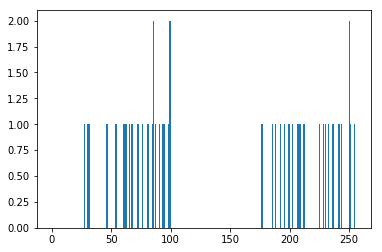

In [179]:
#  仅有一个特征的数据
x = np.random.randint(25,100,25)
y = np.random.randint(175,255,25)
z = np.hstack((x,y)) #    x 轴上两个集中的分布
z = z.reshape((50,1))
z = np.float32(z)
plt.hist(z,256,[0,256]);plt.show()

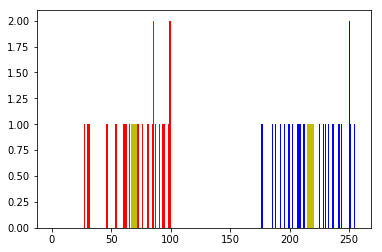

In [194]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS
# Apply KMeans
compactness,labels,centers = cv2.kmeans(z,2,None,criteria,10,flags)

A = z[labels==0]
B = z[labels==1]

# Now plot 'A' in red, 'B' in blue, 'centers' in yellow
plt.hist(A,256,[0,256],color = 'r')
plt.hist(B,256,[0,256],color = 'b')
plt.hist(centers,50,[0,256],color = 'y');
plt.show()



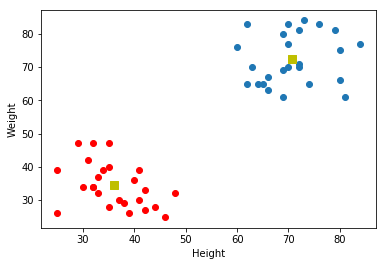

In [198]:
## 多个特征的数据  每个特征占一列     
X = np.random.randint(25,50,(25,2))
Y = np.random.randint(60,85,(25,2))
Z = np.vstack((X,Y))
# convert to np.float32
Z = np.float32(Z)
# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now separate the data, Note the flatten()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.show()

#### 颜色量化
减少图片中颜色数目， 能减少内存，适配低端设备，最终图片只有指定的几种位于聚类中心的颜色  

用聚类中心值替换与其同组的像素值，这样结果图片就只含有指定数目的颜色了

**会出现油画效果**

In [207]:
img = cv2.imread('../images/xueyating.jpg')
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8  # 只保留八种颜色
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
cv2.namedWindow('8 color yanselianghua',cv2.WINDOW_NORMAL)# 默认值是cv2.WINDOW_AUTOSIZE
cv2.imshow('8 color yanselianghua',res2) # 这里的title需要与之前创建的窗口名字一致，不然会再新建一个窗口
cv2.waitKey(0)
cv2.destroyAllWindows()


### 计算摄影学
#### 图像去噪

在图像中找到相似的窗口，求所有窗口的平均值并取代目标的值----------**非局部平均值去噪**  
对于彩色图像，要先转换到 CIELAB 颜色空间，然后对 L 和 AB 成分分别去噪

OpenCV 提供了这种技术的四个变本。
1. cv2.fastNlMeansDenoising() 使用对象为灰度图。
2. cv2.fastNlMeansDenoisingColored() 使用对象为彩色图。
3. cv2.fastNlMeansDenoisingMulti() 适用于短时间的图像序列（灰度图像）
4. cv2.fastNlMeansDenoisingColoredMulti() 适用于短时间的图像序列（彩色图像） 

共同参数有：

- h : 决定过滤器强度。 h 值高可以很好的去除噪声，但也会把图像的细节抹去。 (取 10 的效果不错)
- hForColorComponents : 与 h 相同，但使用与彩色图像。（与 h 相同）
- templateWindowSize : 奇数。 (推荐值为 7)
-  searchWindowSize : 奇数。 (推荐值为 21)

In [212]:
img = cv2.imread('../images/xueyating.jpg')
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
ima=np.hstack((img,dst))
wname='fastNlMeansDenoisingColored'
cv2.namedWindow(wname,cv2.WINDOW_NORMAL)# 默认值是cv2.WINDOW_AUTOSIZE
cv2.imshow(wname,ima) # 这里的title需要与之前创建的窗口名字一致，不然会再新建一个窗口
cv2.waitKey(0)
cv2.destroyAllWindows()


#### 视频
cv2.fastNlMeansDenoisingMulti(noisy_img, 需要去噪帧, 用于去噪的相邻帧数（奇数）, None, h, templateWindowSize, WindowSize)

In [243]:
cap = cv2.VideoCapture('../samples/data/768x576.avi')
# create a list of first 5 frames
img = [cap.read()[1] for i in range(5)]
# convert all to grayscale
gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in img]
# convert all to float64
gray = [np.float64(i) for i in gray]
# create a noise of variance 25
noise = np.random.randn(*gray[1].shape)*10
# Add this noise to images
noisy = [i+noise for i in gray]
# Convert back to uint8
noisy = [np.uint8(np.clip(i,0,255)) for i in noisy]
# Denoise 3rd frame considering all the 5 frames
dst = cv2.fastNlMeansDenoisingMulti(noisy, 2, 5, None, 10, 7, 21)
ima=np.hstack((np.uint8(gray[2]),np.uint8(noisy[2]),np.uint8(dst)))
wname='original   noisy    denoise'
cv2.namedWindow(wname,cv2.WINDOW_NORMAL)# 默认值是cv2.WINDOW_AUTOSIZE
cv2.imshow(wname,ima) # 这里的title需要与之前创建的窗口名字一致，不然会再新建一个窗口
cv2.waitKey(0)
cv2.destroyAllWindows()


## 图像修补
1. cv2.inpaint()   
从这个区域的边界开始向区域内部慢慢前进，首先填充区域边界像素, 选取待修补像素周
围的一个小的邻域，使用这个邻域内的归一化加权更新待修复像素， 再逐步向内推进。 其中对靠近正常边界像素点和在轮廓上的像素点，靠近带修复点的像素点给予更高的权重
2. cv2.INPAINT_NS  
沿着正常区域的边界向退化区域的前进，匹配待修复区域中的梯度向量来延伸等光强线


In [ ]:
img = cv2.imread('../images/xueyating.jpg')
mask=np.ones(img.shape)
mask[2500:2655,1100:1210]=0
mask[700:955,800:1100]=0
mask=np.uint8(mask)
timg=img*mask
dst1 = cv2.inpaint(img,mask[:,:,1],21,cv2.INPAINT_TELEA)
dst2 = cv2.inpaint(img,mask[:,:,1],21,cv2.INPAINT_NS)


In [266]:
ima1=np.hstack((img,timg))
ima2=np.hstack((dst1,dst2))
ima=np.vstack((ima1,ima2))
wname='INPAINT_TELEA,   cv2.INPAINT_NS '
cv2.namedWindow(wname,cv2.WINDOW_NORMAL)# 默认值是cv2.WINDOW_AUTOSIZE
cv2.imshow(wname,ima) # 这里的title需要与之前创建的窗口名字一致，不然会再新建一个窗口
cv2.waitKey(0)
cv2.destroyAllWindows()


##  对象检测
Haar 级联检测人脸
加载训练好的分类器来根据灰度图像检测人脸位置

In [6]:
face_cascade = cv2.CascadeClassifier('../samples/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../samples/haarcascades/haarcascade_eye.xml')
img = cv2.imread('../images/xueyating.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

wname='face detect '
cv2.namedWindow(wname,cv2.WINDOW_NORMAL)# 默认值是cv2.WINDOW_AUTOSIZE
cv2.imshow(wname,img) # 这里的title需要与之前创建的窗口名字一致，不然会再新建一个窗口
cv2.waitKey(0)
cv2.destroyAllWindows()